In [33]:
import pandas as pd
import sqlite3
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import math # for haversine function
import folium  # heat map
from folium.plugins import HeatMap  # heat map

In [34]:
# Database paths
# ALEX'S PATH
database_db = 'blue_bikes.db'
bike_lanes_geojson = 'bos-bike-paths-2022.geojson'
# ZACK'S PATH
database_db = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/blue_bikes.db'
bike_lanes_geojson = 'Data/bos-bike-paths-2022.geojson'


# SHARED GITHUB PATHS - should work for all users
# Physical geographies
boston_city_shp = "https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/Boston_Neighborhoods/Boston_Neighborhoods.shp"
water_boundaries_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/main/Data/Background_map_data/Hydrography/Hydrography_(Polygon).shp'
munis_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/main/Data/Background_map_data/Municipal_bounaries/TOWNSSURVEY_POLY.shp'
# Sea Level Rise
sea_level_9in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/9_inch_SLR_10_pct_storm/_9inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
sea_level_21in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/21_inch_SLR_10_pct_storm/_21inch_Sea_Level_Rise__10pct_Annual_Flood.shp'
sea_level_36in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/36_inch_SLR_10_pct_storm/_36inch_Sea_Level_Rise_10pct_Annual_Flood.shp'

In [35]:
# Connection to database:
con = sqlite3.connect(database_db)

In [38]:
# Views:
boston_crashes_2017 = pd.read_sql("SELECT * FROM boston_crash_reports_2017 WHERE mode_type = 'bike'", con)
boston_crashes_2022 = pd.read_sql("SELECT * FROM boston_crash_reports_2022 WHERE mode_type = 'bike'", con)
boston_fatalities_2017 = pd.read_sql("SELECT * FROM boston_fatality_report_2017", con)
boston_fatalities_2022 = pd.read_sql("SELECT * FROM boston_fatality_report_2022", con)
bike_5001 = pd.read_sql("SELECT * FROM bike_5001", con)
# Tables:
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2017", con)
bluebike_trips2022 = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
boston_crash_reports = pd.read_sql("SELECT * FROM boston_crash_reports", con)
boston_fatality_report = pd.read_sql("SELECT * FROM boston_fatality_report", con)
current_bluebikes_stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

## Common shapefiles used throughout notebook

In [50]:
def read_shapefile(shp_path, filter_query = None):
    """
    Creates a projected geodataframe from a provided path to shapefile.
    Also filters geodataframe is filter is provided.
    @param shp_path (str): path to shapefile.
    @param filter_query (str): string of filter query. Defaults to None (skips step).
    Returns: geo_df, the new geodataframe object.
    """
    
    # Create geodataframe from path to shapefile
    geo_df = gpd.read_file(shp_path, type='Polygon')
    # Filter if filter query provided
    if filter_query is not None:
        geo_df = geo_df.query(filter_query)
    # Convert to projection of choice
    geo_df = geo_df.to_crs('EPSG:4326')
    
    return geo_df

In [51]:
def df_to_points(df, long = 'long', lat = 'lat'):
    """
    Creates a geodataframe from a dataframe with lat/long fields.
    @df: pandas dataframe.
    @param: long (str): name of long field in dataframe.
    @param: lat (str): name of lat field in dataframe.
    Returns: geo_df, the geodataframe with location data.
    """
    
    # Mapping a dataframe with lat/long data to a point file
    points = [Point(xy) for xy in zip(df[long], df[lat])]
    #Convert that point layer into a geodataframe object
    geo_df = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=points)
        
    return geo_df

In [48]:
# Shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = read_shapefile(boston_city_shp)
# Boston hydrography boundaries (https://data.boston.gov/dataset/hydrography-polygon)
water = read_shapefile(water_boundaries_path)
# Massachusetts municipal boundaries (https://www.mass.gov/info-details/massgis-data-municipalities)
muni_query = "TOWN in ('BOSTON', 'CAMBRIDGE', 'BROOKLINE',\
                    'NEWTON', 'WATERTOWN', 'SOMERVILLE',\
                    'BELMONT', 'CHELSEA', 'EVERETT', 'WINTHROP')"
munis = read_shapefile(munis_path, muni_query)
# Read in bike lanes file
bike_lanes = gpd.read_file(bike_lanes_geojson)

# Boston 2022 Bike Lanes, Crashes & Fatalities 

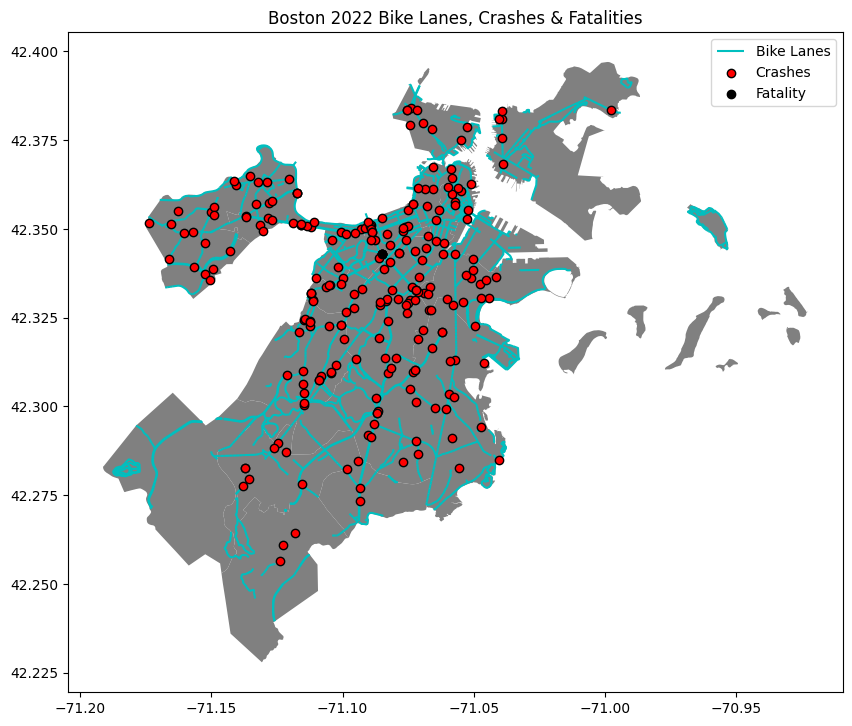

In [39]:
# Create geodataframe object from dataframe with lat/long data
boston_crash_reports_geodf = df_to_points(boston_crashes_2022, 'long', 'lat')
# Repeat step above for fatalies data
boston_fatality_report = boston_fatalities_2022[boston_fatalities_2022["mode_type"] == 'bike']
# Create geodataframe object from dataframe with lat/long data
boston_fatality_report = df_to_points(boston_fatality_report, 'long', 'lat')

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# Plot background images
bike_lanes.plot(ax=ax, color='c')  # bike lanes
boston_neighborhoods.plot(ax=ax, color='grey')  # neighborhoods
# Plot data
boston_crash_reports_geodf.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r', zorder=4)
boston_fatality_report.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='k', zorder=5)
# Figure information
plt.title("Boston 2022 Bike Lanes, Crashes & Fatalities")
plt.legend(["Bike Lanes", "Crashes", "Fatality"], loc=0, frameon=True)
plt.show()

In [41]:
print(f"There were {boston_crashes_2017.shape[0]} bike crashes in 2017.")  # 2017 crash counts
print(f"There were {boston_crash_reports_geodf.shape[0]} bike crashes in 2022.")
print(f"There were {boston_fatality_report.shape[0]} bike fatalities in 2022.")

There were 390 bike crashes in 2017.
There were 242 bike crashes in 2022.
There were 1 bike fatalities in 2022.


# Sea Level Rise and Blue Bike Stations

In [9]:
# Create a copy of station data
stations = current_bluebikes_stations.copy()
# Mapping a dataframe with lat/long data to a geodataframe
stations = df_to_points(stations, 'Longitude', 'Latitude')
# Clip stations to just in Boston
stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)

# Add 9, 21, and 36 inch level rise 10 pct storm
sea_level_9in = read_shapefile(sea_level_9in_path)
sea_level_21in = read_shapefile(sea_level_21in_path)
sea_level_36in = read_shapefile(sea_level_36in_path)

# Spatially clip the points to the polygons
clipped_stations_SLR9 = gpd.clip(stations, sea_level_9in, keep_geom_type=False)
clipped_stations_SLR21 = gpd.clip(stations, sea_level_21in, keep_geom_type=False)
clipped_stations_SLR36 = gpd.clip(stations, sea_level_36in, keep_geom_type=False)

# number of stations underwater!
print(clipped_stations_SLR9.count()[0], "stations impacts by 9 inch sea level rise 10 percent storm.")
print(clipped_stations_SLR21.count()[0], "stations impacts by 21 inch sea level rise 10 percent storm.")
print(clipped_stations_SLR36.count()[0], "stations impacts by 36 inch sea level rise 10 percent storm.")

8 stations impacts by 9 inch sea level rise 10 percent storm.
23 stations impacts by 21 inch sea level rise 10 percent storm.
54 stations impacts by 36 inch sea level rise 10 percent storm.


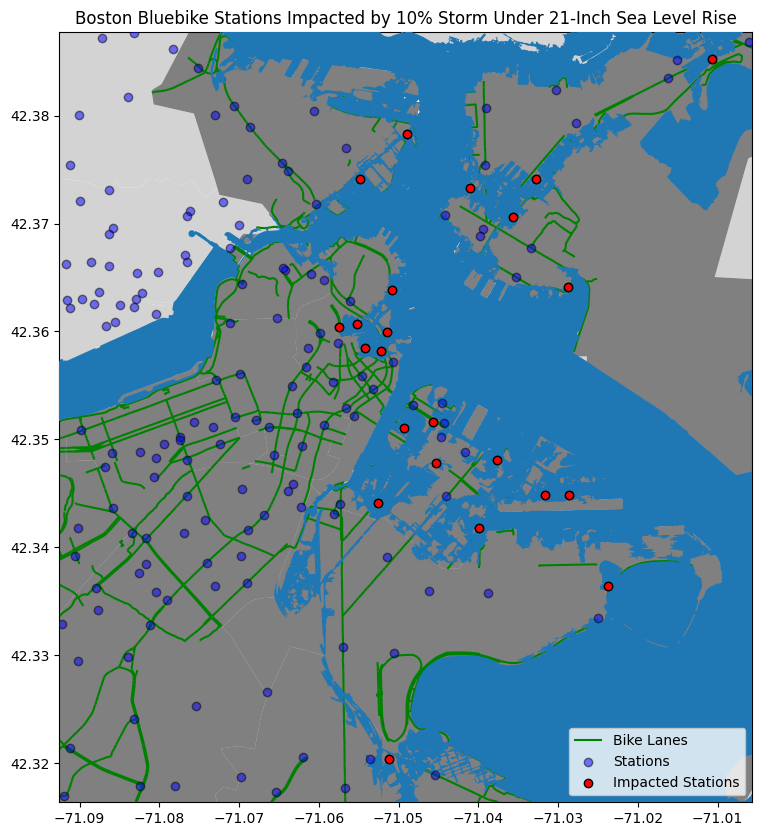

In [49]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot background images
munis.plot(ax=ax, color='lightgrey', edgecolor="None", zorder=0)  # other munis
boston_neighborhoods.plot(ax=ax, color='grey', zorder=1)  # Boston
bike_lanes.plot(ax=ax, color='g', label="Bike Lanes", zorder=2)  # bike lanes

# Plot Sea Level Rise event
sea_level_21in.plot(ax=ax, zorder=3)

# Plot point data
stations.plot(edgecolor='#000000', legend=True,
                      categorical=False, ax=ax,
                      label="Stations", color='b',
                      alpha=0.5, zorder=4)
clipped_stations_SLR21.plot(edgecolor='#000000', legend=True,
                            categorical=False, ax=ax,
                            label="Impacted Stations",
                            color='r', zorder=4)

# Set zoom to just the waterfront area
minx, miny, maxx, maxy = clipped_stations_SLR36.total_bounds
ax.set_xlim(minx-0.01, maxx+0.005)
ax.set_ylim(miny-0.0025, maxy+0.0025)

# Map elements
plt.title("Boston Bluebike Stations Impacted by 10% Storm Under 21-Inch Sea Level Rise")
ax.legend()
plt.show()

In [23]:
# List of stations that have been inundated
filter_criteria = list(clipped_stations_SLR21['Name'])
# Get rides lost due to SLR in 2022
start_station_filter = bluebike_trips2022['start_station_name'].isin(filter_criteria)
end_station_filter = bluebike_trips2022['end_station_name'].isin(filter_criteria)

# Filter for start and end stations that are inundated
lost_trips = bluebike_trips2022[start_station_filter | end_station_filter]

# Number of trips lost
print("There were", lost_trips.shape[0], "trips lost to a 10% storm with 21 inch SLR (2022 trips)")
# Percent of total trips lost
prct_trips = lost_trips.shape[0] / bluebike_trips2022.shape[0] * 100  # number now in percent not decimal
print(f"This accounts for {prct_trips:.2f}% of total trips in 2022")

There were 314801 trips lost to a 10% storm with 21 inch SLR (2022 trips)
This accounts for 8.38% of total trips in 2022


Note to self: Sea level rise next step includes joining inundated stations to the full table, and then getting the number of trips generated from these stations. 

Then, compare the number of trips generated from these stations to the total number of trips taken.

# Following bike #5001 around Boston

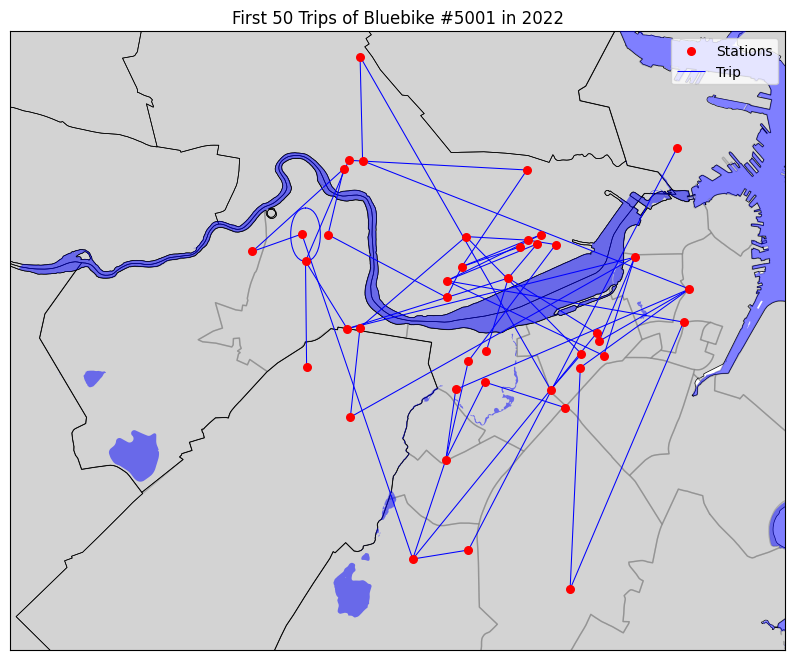

In [12]:
# Select 50 rides by bike #5001
bike5001_network = pd.read_sql("SELECT * FROM bike_5001 ORDER BY starttime LIMIT 50", con)

# Create network graph object
G = nx.Graph()

# Add nodes and edges, including geographic information
for _, row in bike5001_network.iterrows():
  # Add the nodes to the graph
  G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  G.add_node(row.end_station_name, pos=(row.end_station_longitude, row.end_station_latitude))
  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)

# Draw the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot hydrography layer
water.plot(ax=ax, color='b', alpha=0.5, zorder=5)
# Plot only the internal color of other munis
munis.plot(ax=ax, color='lightgrey', edgecolor="None", zorder=1)
# Plot neighborhoods of Boston
boston_neighborhoods.plot(ax=ax, color='None', alpha=0.5, edgecolor="grey", zorder=2)
# Plot munis again - only the border this time
munis.plot(ax=ax, color='None', edgecolor="black", linewidth=0.5, zorder=3)

# Working with network
position = nx.get_node_attributes(G, 'pos')
# Draw edges and nodes
nodes = nx.draw_networkx_nodes(G, position, node_size=30, node_color='red', label="Stations")
edges = nx.draw_networkx_edges(G, position, node_size=30, width=0.75, edge_color='blue', label="Trip")
nodes.set_zorder(10)
edges.set_zorder(9)

# Set map scale
ax.set_xlim(-71.18, -71.045)
ax.set_ylim(42.31, 42.39)
        
# Add legend   
plt.legend()
plt.title("First 50 Trips of Bluebike #5001 in 2022")
plt.show()

# Total distance traveled by Bluebikes in 2022 and car emissions saved

In [13]:
# Thanks professor! 
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates distance between two lat/long points on Earth.
    Thank you/credit to Prof. Rachlin for providing this code. Minor edits made to ensure lat/long type.
    @param lat1, lon1: lat and lon value for first point.
    @param lat2, lon2: lat and lon value for second point.
    Returns: d, the distance between two points.
    """
    
    # Convert string to float
    lat1 = float(lat1)
    lon1 = float(lon1)
    lat2 = float(lat2)
    lon2 = float(lon2)
    
    radius_earth = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius_earth * c

    return d


# Calculate total trip distance for a whole dataframe
def trip_dist_calc(df):
    """
    Creates a column "trip_distance" in inputted dataframe, based on start and end station lat/long.
    Operates under the assumtion that the lat/long columns names are the same for each df.
        They should be, I created them in a standardized way for Bluebike trips.
    Modifies dataframe in place, no need to return anything.
    """
    
    df['trip_distance'] = df.apply(lambda row: haversine(row['start_station_latitude'], 
                     row['start_station_longitude'], 
                     row['end_station_latitude'],
                     row['end_station_longitude']), axis=1)

In [53]:
# Apply haversine function to start and end stations. Column is in kilometers
trip_dist_calc(bluebike_trips2017)
trip_dist_calc(bluebike_trips2022)

Data from EPA: 
"How much tailpipe carbon dioxide (CO2) is emitted from driving one mile?
 The average passenger vehicle emits about 400 grams of CO2 per mile."
 
Also from EPA: 
"A typical passenger vehicle emits about 4.6 metric tons of CO2 per year."
 
Source: https://www.epa.gov/greenvehicles/tailpipe-greenhouse-gas-emissions-typical-passenger-vehicle

Not trying to filter out trips that start and end at the same station. This calculation is fundamentally an underestimate because it calculates linear distance between stations, not actual total distance travelled. So, trips that start and end at the same station won't add anything to the calculation, so not worth editing out.

In [54]:
# For background, get number of trips each year (number of rows in dataframe)
trips2017 = int(bluebike_trips2017.shape[0])
trips2022 = int(bluebike_trips2022.shape[0])

# Get total kilometers traveled and covert to miles (converstion factor: 0.621371)
trip_mi_2017 = int(bluebike_trips2017['trip_distance'].sum() * 0.621371)
trip_mi_2022 = int(bluebike_trips2022['trip_distance'].sum() * 0.621371)

# Get total emissions saved, based on average vehicle tailpipe emission per mile
total_emissions_2017 = int(400 * trip_mi_2017 / 1000000)  # convert from grams to metric tonnes
total_emissions_2022 = int(400 * trip_mi_2022 / 1000000)  # convert from grams to metric tonnes

# Calculate average trip length
avg_trip_len_2017 = trip_mi_2017 / trips2017
avg_trip_len_2022 = trip_mi_2022 / trips2022

# Create a table with all this info
tripdata = pd.DataFrame({'2017': [trips2017, trip_mi_2017, total_emissions_2017],
                         '2022': [trips2022, trip_mi_2022, total_emissions_2022],
                         'Increase': [(trips2022 - trips2017),
                                       (trip_mi_2022 - trip_mi_2017),
                                       (total_emissions_2022 - total_emissions_2017)]},
                        index=['Total number of trips', 'Total trip miles', 'Minimum metric tons CO2 emissions'])
# Print information
print(tripdata, '\n')
print(f"Average trip length in 2017: {avg_trip_len_2017:.2f} miles")
print(f"Average trip length in 2022: {avg_trip_len_2022:.2f} miles")

                                      2017     2022  Increase
Total number of trips              1313774  3757281   2443507
Total trip miles                   1744623  4467589   2722966
Minimum metric tons CO2 emissions      697     1787      1090 

Average trip length in 2017: 1.33 miles
Average trip length in 2022: 1.19 miles


# Heatmap of 2017 crashes

In [42]:
# Extract lat long data from bike crash data
bike_crashes_2017_loc = bike_crashes_2017[['lat', 'long']]
# Turn into a list of lists of lat, long data
heatmap_data = [[row['lat'], row['long']] for _, row in bike_crashes_2017_loc.iterrows()]

# Create map item
crashmap_2017 = folium.Map(location = [42.3601, -71.0589], zoom_start=13) 
# Create heatmap
HeatMap(heatmap_data).add_to(crashmap_2017)
# Add bike lane GeoJson data to map
#layer = folium.GeoJson(open(bike_lanes_geojson, "r").read())
#layer.add_to(crashmap_2017)

# Display map
crashmap_2017

# Bluebike stations in Boston

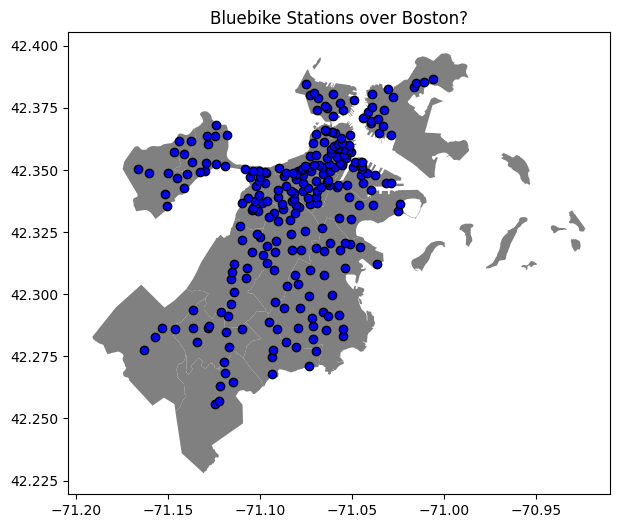

In [17]:
# Create geodataframe from station data
stations = df_to_points(current_bluebikes_stations, long = 'Longitude', lat = 'Latitude')
# Clip stations to the boston neighborhood map
clipped_stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)

# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Plot map
boston_neighborhoods.plot(ax=ax, color='grey')
# Plot station data
clipped_stations.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='b')
# Update figure
plt.title("Bluebike Stations over Boston?")
plt.show()

# Average  Duration by Day

Add yearly average line?

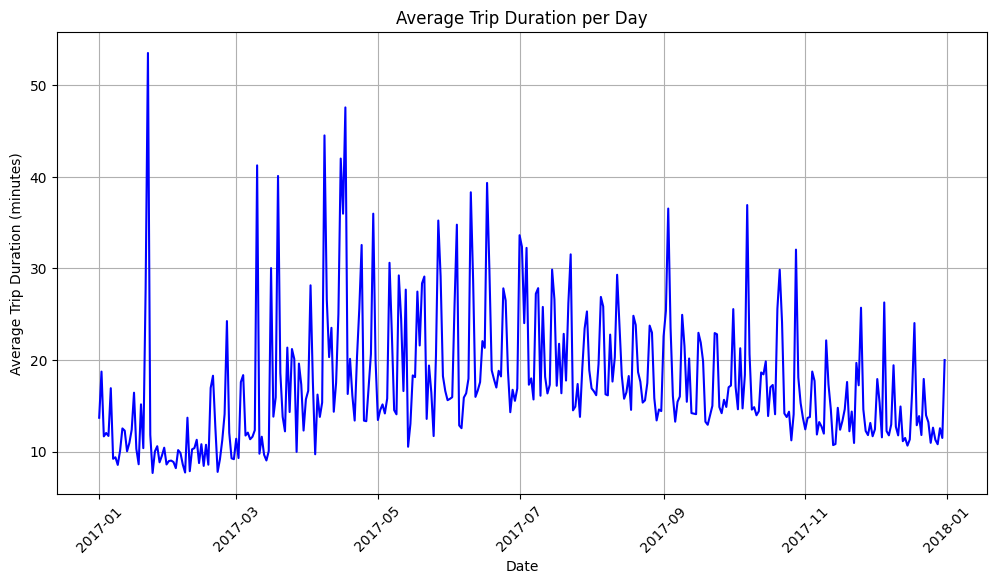

In [18]:
# Avg. Duration by Day
blue_bike_trip_data = bluebike_trips2017.loc[::,['tripduration','starttime', 'stoptime']]
# Change to date types in pd
blue_bike_trip_data['starttime'] = pd.to_datetime(blue_bike_trip_data['starttime'])
blue_bike_trip_data['stoptime'] = pd.to_datetime(blue_bike_trip_data['stoptime'])

# Convert trip duration from seconds to minutes
blue_bike_trip_data['tripduration'] = blue_bike_trip_data['tripduration'] / 60
# Calculate average daily trip duration
daily_avg_trip_duration = blue_bike_trip_data.groupby(blue_bike_trip_data['starttime'].dt.date)['tripduration'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_trip_duration.index, daily_avg_trip_duration, color='blue')
plt.title('Average Trip Duration per Day')
plt.xlabel('Date')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Number of Bicycle Crashes per Week

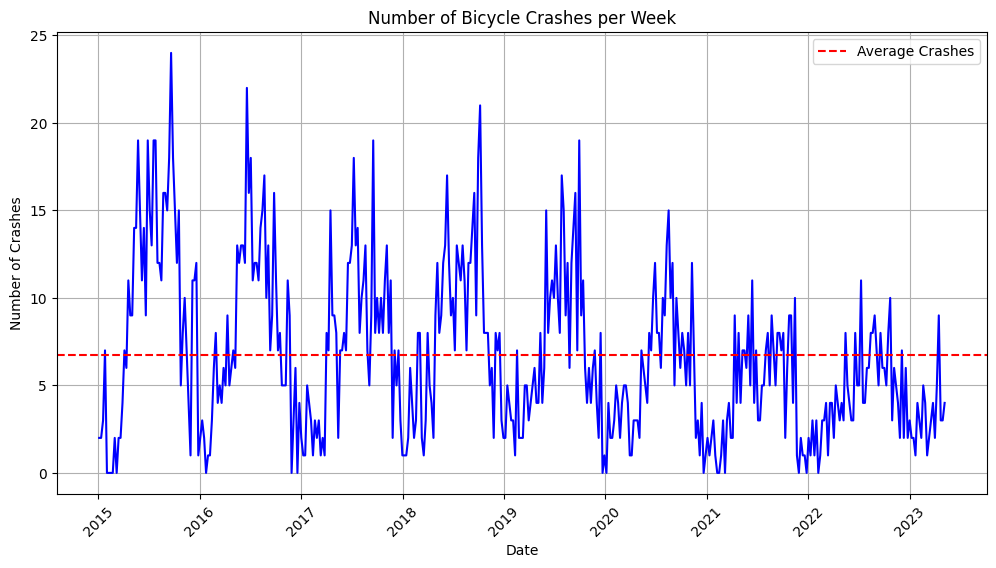

In [19]:
# Filter crashes from all years to just bike crashes
bos_crashes = boston_crash_reports.copy()
bos_crashes = bos_crashes[bos_crashes["mode_type"] == 'bike'] #filter to just bike

# Convert column to datetime
bos_crashes['dispatch_ts'] = pd.to_datetime(bos_crashes['dispatch_ts'])

# Group by week and count the number of crashes per week
crashes_per_week = bos_crashes.groupby(pd.Grouper(key='dispatch_ts', freq='W')).size()

# Calculate the average crashes per week
average_crashes = crashes_per_week.mean()

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(crashes_per_week.index, crashes_per_week, color='blue')
plt.axhline(y=average_crashes, color='red', linestyle='--', label='Average Crashes')
plt.title('Number of Bicycle Crashes per Week')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

Kind of intresting to look at. I have seen things saying a lot of the bike lanes are new so it could be that new bike lanes are decreasing crashes, or less people are reporting crashes to the police. ? Not really sure how we will be able to use this
